In [1]:
import torch

## Two types of Quantization
**Asymmetric:** we map [$r_{min}$ , $r_{max}$] to [$q_{min}$ , $q_{max}$]. Which we were doing uptill now.<br>
**Symmetric:** we map [–$r_{max}$ , $r_{max}$] to [–$q_{max}$ , $q_{max}$]. Where we can set
**$r_{max}$ = max(|$r_{tensor}$|)**.<br>
Here we don’t need to use the zero point (z=0), this happens because the FP range and the quantized range are symmetric w.r.t zero.
The quantized tensor is simply the original tensor divided by the scale that we run and cast to the data type of the quantized tensor, and the scale S is simply $r_{max}$ / $q_{max}$.

In [2]:
def get_q_scale_symmetric(tensor, dtype=torch.int8):
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max

    return r_max/q_max

In [3]:
#implementing on a 4x4 matrix
test_tensor = torch.randn((4, 4))

In [4]:
test_tensor

tensor([[ 1.0500, -1.1420, -0.2417, -0.2046],
        [-0.8907,  1.5788,  0.5660,  1.6085],
        [-0.4794,  0.7413, -1.9404, -0.1646],
        [ 0.2168, -0.0590,  0.2522, -0.4328]])

In [5]:
get_q_scale_symmetric(test_tensor)

0.015278718602938914

### Quantization

In [6]:
from helper import linear_q_with_scale_and_zero_point

In [7]:
def linear_q_symmetric(tensor, dtype=torch.int8):
    scale = get_q_scale_symmetric(tensor)
    
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor,
                                                     scale=scale,
                   # in symmetric quantization zero point is = 0    
                                                    zero_point=0,
                                                      dtype=dtype)
    
    return quantized_tensor, scale

In [8]:
quantized_tensor, scale = linear_q_symmetric(test_tensor)

### Dequantization

In [9]:
from helper import linear_dequantization, plot_quantization_errors
from helper import quantization_error

In [10]:
dequantized_tensor = linear_dequantization(quantized_tensor,scale,0)

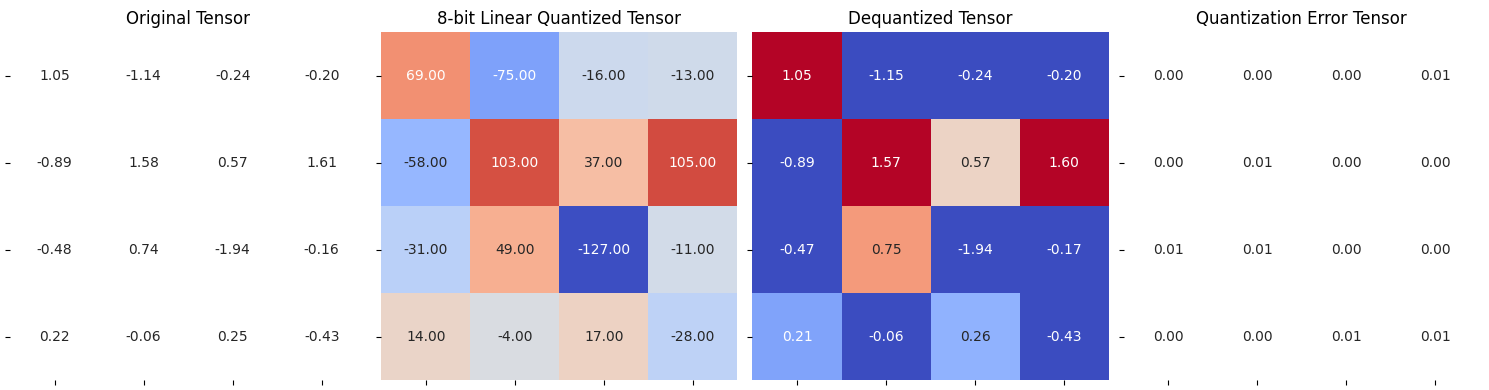

In [11]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

In [12]:
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor)}""")

Quantization Error : 2.1057938283775002e-05


**Utilization of quantized range:**<br>
- When using asymmetric quantization, the quantized range is fully utilized.
- When symmetric mode, if the float range is biased towards one side, this will result in a quantized range where a part of the range is dedicated to valeus that we will never see. (eg. ReLU where the output is positive).<br>

**Simplicity:** Symmetric mode is much simpler compared to assymetric mode.<br>
**Memory:** We don't store the zero-point for symmetric quantization.